## Movie Classifier using Augmented Data: Overview

1. Data Augmentation:
    - To handle Data Imbalance
    - Method 1: Converted text to 16 different languages and re-translated the text back to English. This created variations in the text descriptions.
    - Method 2: Created a Markov Chain using the entire training data. Generated text description samples from this chain.
    - Generated the title for the augmented Movie Descriptions randomly.
    - Picked 100 Augmented samples(from method1 and method2 datasets collectively) for selected Genres
    - Integrated the Augmented data with the Train Data¶
    

2. Indexing the Vocabulary:

    - Used TextVectorization to index the vocabulary found in the dataset. Later, we use the same layer instance to vectorize the samples. Our layer will only consider the top 20,000 words, and will truncate or pad sequences to be actually 200 tokens long.

3. Data Pre-Processing:
   - Did traditional pre-processing of the data: Lowercasing, Removing twitter handles, stopwords, URLs, extra spaces, etc.
   - Encoded the categories

4. Embedding:
    - Used pre-trained GLOVE Embeddings. Found 400000 word vectors 
    - Created the Embedding Matrix: Words not found in embedding index will be all-zeros. This includes the representation for "padding" and "OOV".
    - Created tensorflow.keras.layers.Embedding layer and embedded the text sequences.

5. Modelling:
    - Creating the Model
    - Vectoring the Data
    - Fitting the Model
    - Model Summary:    
         - input_1 (InputLayer)                                                                    
         - embedding (Embedding Layer)                                       
         - bidirectional (Bidirectional LSTM layer)                                                              
         - dense (Dense)   
         - dropout (Dropout)      
         - dense_1 (Dense)
         
         


6. Evaluation:
    - Test Accuracy: 57.91%
    - After augmenting the data for classes which had less samples, the accuracy increases for these classes.

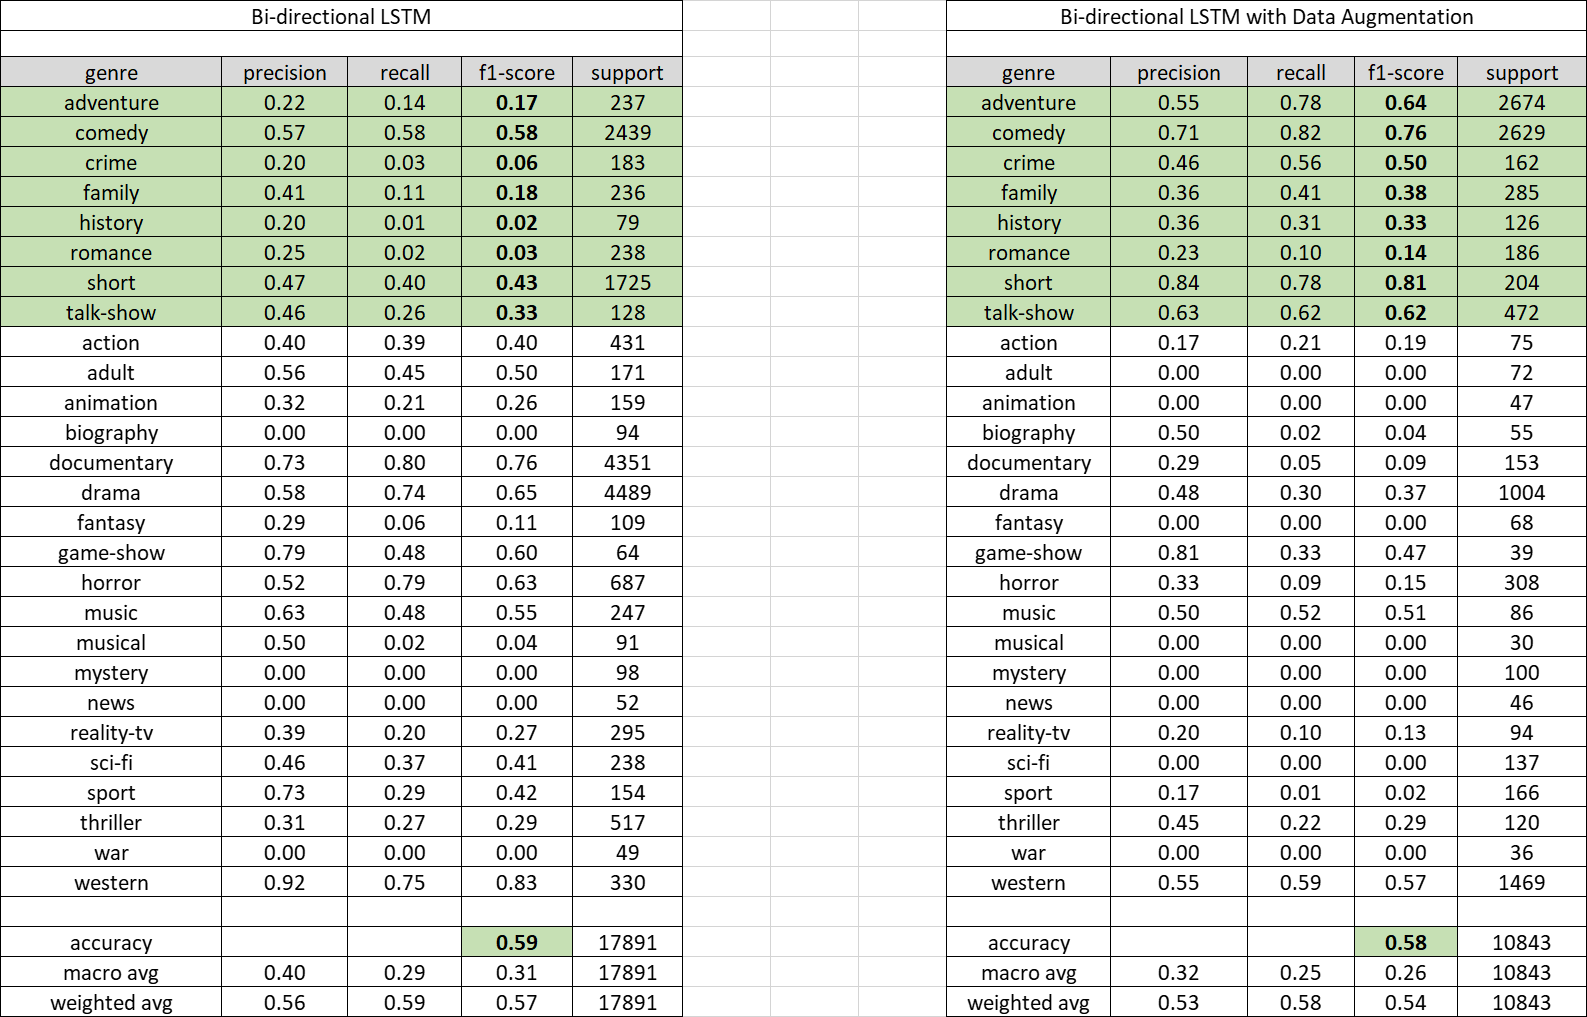

## I. Data Augmention

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import random
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings("ignore")

### Method 1: Converting Descriptions to different languages and re-converting back to English

In [2]:
from textblob import TextBlob
from textblob.translate import NotTranslated
import random


def data_augmentation(message,no_aug, intent,title):
    sr = random.SystemRandom()
    language = ["es", "de", "fr", "ar", "te", "hi", "ja", "fa", "sq", "bg", "nl", "gu", "ig", "kk", "mt", "ps"]
    text = TextBlob(message)
    lang=sr.choice(language)
    text = text.translate(from_lang='en', to=lang)   ## Converting to random langauge for meaningful variation
    text = text.translate(from_lang=lang, to="en")
    #file = open('Final_augmented_data.txt','a')
    file.write(str(no_aug)+' :::'+title+':::'+intent+'::: '+str(text)+"\n")
    #file.close()

In [3]:
train_df=pd.read_csv('train_df.csv')

In [4]:
Genre_count = train_df.Genre.value_counts().to_dict()
Genre_count

{' drama ': 10939,
 ' documentary ': 10467,
 ' comedy ': 5978,
 ' short ': 4069,
 ' horror ': 1732,
 ' thriller ': 1283,
 ' action ': 1030,
 ' western ': 828,
 ' reality-tv ': 698,
 ' family ': 631,
 ' adventure ': 609,
 ' music ': 569,
 ' romance ': 535,
 ' sci-fi ': 521,
 ' adult ': 470,
 ' crime ': 405,
 ' animation ': 404,
 ' sport ': 346,
 ' talk-show ': 316,
 ' mystery ': 251,
 ' fantasy ': 251,
 ' musical ': 222,
 ' biography ': 219,
 ' history ': 196,
 ' game-show ': 155,
 ' news ': 145,
 ' war ': 102}

### Selecting the less populated categories for Augmentation

In [11]:
mov = [' war ',' musical ',' biography ',' new ',' history ',' mystery ',' fantasy ', ' animation ']

In [1]:
## Loop to interate all messages
import numpy as np
import math

max_intent_count=10939
no_aug=1
for intent, count in Genre_count.items():
    count_diff = max_intent_count - count
    file = open('Final_augmented_data.txt','a')
    if intent in mov:#count_diff>5000:
        for i in range(0,1000):
            random_number = random.randint(0, count-1)    
            x=train_df[train_df['Genre']==intent]
            x=x.reset_index(drop=True)
            text=x['Description'][random_number]
            title=x['Title'][random_number]
            data_augmentation(text, no_aug, intent,title)
            no_aug = no_aug+1
    file.close()

### Method 2: Data Augmentation Using Markov Chain

In [1]:
## Import python library
import pandas as pd
import nltk

pd.set_option('display.max_colwidth', 5000)
## Read file
file_name = 'train_df.csv'
## Read file using pandas
train_df = pd.read_csv(file_name)

In [3]:
Genre_count = train_df.Genre.value_counts().to_dict()
Genre_count

{' drama ': 10939,
 ' documentary ': 10467,
 ' comedy ': 5978,
 ' short ': 4069,
 ' horror ': 1732,
 ' thriller ': 1283,
 ' action ': 1030,
 ' western ': 828,
 ' reality-tv ': 698,
 ' family ': 631,
 ' adventure ': 609,
 ' music ': 569,
 ' romance ': 535,
 ' sci-fi ': 521,
 ' adult ': 470,
 ' crime ': 405,
 ' animation ': 404,
 ' sport ': 346,
 ' talk-show ': 316,
 ' mystery ': 251,
 ' fantasy ': 251,
 ' musical ': 222,
 ' biography ': 219,
 ' history ': 196,
 ' game-show ': 155,
 ' news ': 145,
 ' war ': 102}

In [7]:
def data_augmentation_markovify(text, no_aug, genre,title):
    file = open('augmented_data_markovify.txt','a')
    file.write(str(no_aug)+' ::: '+title+' :::'+genre+'::: '+text+"\n")
    file.close()

### Generating the title of the Movie Descriptions randomly

In [128]:
from random_word import RandomWords
r = RandomWords()

max_genre_count=10939
no_aug=34728
for genre, count in Genre_count.items():
    count_diff = max_genre_count - count
    if count_diff>10715:
        print(genre)
        for i in range(0,2000):
            try:
                corpus=train_df[train_df['Genre']==genre]['Description'].to_string(index=False) 
                text_model = markovify.Text(corpus, state_size=3)
                new_text=[]
                for i in range(5):
                    new_text.append(text_model.make_short_sentence(280))
                new_text=" ".join(new_text)
                title = r.get_random_word()
                data_augmentation_markovify(new_text, no_aug, genre,title)
                no_aug = no_aug+1
            except:
                pass

### Integrating the Augmented data with the Train Data

In [3]:
train_df=pd.read_csv('train_df.csv')
animation_df=pd.read_csv('augmented_data_animation.txt',sep=':::',names=['Index','Title','Genre','Description'])
family_df=pd.read_csv('augmented_data_crime_family.txt',sep=':::',names=['Index','Title','Genre','Description'])
romance_df=pd.read_csv('augmented_data_romance.txt',sep=':::',names=['Index','Title','Genre','Description'])
thriller_df=pd.read_csv('augmented_data_thriller.txt',sep=':::',names=['Index','Title','Genre','Description'])
short_df=pd.read_csv('augmented_data_short.txt',sep=':::',names=['Index','Title','Genre','Description'])
mystery_df=pd.read_csv('augmented_data_mystery_fantasy_musical_history_biography.txt',sep=':::',names=['Index','Title','Genre','Description'])
music_df=pd.read_csv('augmented_data_music.txt',sep=':::',names=['Index','Title','Genre','Description'])
scifi_df=pd.read_csv('augmented_data_scifi.txt',sep=':::',names=['Index','Title','Genre','Description'])
war_df=pd.read_csv('augmented_data_adult_war.txt',sep=':::',names=['Index','Title','Genre','Description'])
game_df=pd.read_csv('game_show_augmented_data.txt',sep=':::',names=['Index','Title','Genre','Description'])
markov_aug_df=pd.read_csv('markov_aug_df.csv')
aug_df = pd.concat([animation_df,family_df,romance_df,thriller_df,short_df,mystery_df,music_df,scifi_df,war_df,game_df,markov_aug_df],ignore_index=True)
#aug_df = pd.read_csv('markov_aug_df.csv')

aug_df = aug_df.sample(frac = 1).reset_index(drop=True)

In [5]:
aug_df.head()

,Index,Title,Genre,Description,Unnamed: 0
0,44543,shahs,war,Intense bonds between man and horse developed...,44542.0
1,1361,Final Fantasy XI: Wings of the Goddess (2007),fantasy,The fourth expanse to the final immortal imag...,NaN
2,1007,"""Timeline Alpha"" (2017)",sci-fi,Schedule alphabet is an event series. What is...,NaN
3,17314,whiter,music,In the aftermath of Esbjorn Svenssons untimel...,17313.0
4,39554,disagreeably,history,"General Ludendorf, who used to be the greates...",39553.0


In [6]:
train_df.head()

,Unnamed: 0.1,Unnamed: 0,Index,Title,Genre,Description
0,0,23699,23700,"""NigaHiga"" (2007)",comedy,"Jeremy Lin retires from basketball, not to pl..."
1,1,24841,24842,Popat (2013),drama,"Based in a village in Kolhapur, Popat is a st..."
2,2,37358,37359,Maestri (2014),documentary,For young conductors the opportunity to get t...
3,3,48000,48001,Me vs. Comic-Con: Who's Better? (2007),short,San Diego Comic-Con International is the larg...
4,4,53004,53005,Plumb and Dumber (1995),adult,"Barney's wife, Maggie, kicks him out of their..."


In [7]:
aug_df = aug_df[['Title','Genre','Description']]
train_df = train_df.iloc[:,3:6]

In [8]:
print("Shape of train data: ",train_df.shape)
print("Shape of augmented data: ",aug_df.shape)

Shape of train data:  (43371, 3)
Shape of augmented data:  (61675, 3)


In [10]:
#Value Counts in Original Data
cnt_org= dict(train_df.Genre.value_counts())
print(cnt_org)

#Value Counts in Augmented Data
cnt_aug= dict(aug_df.Genre.value_counts())
print(cnt_aug)

max_records= 11000

genre_to_augment = [' comedy ',' western ',' horror ',' talk-show ',' short ',' family ',' sport ',' adult ',' war ',' musical ']
new_df=pd.DataFrame()
for key,val in cnt_org.items():
    if val>max_records:
        gen_df= train_df[train_df['Genre']==key][0:max_records]
        new_df= pd.concat([new_df,gen_df],ignore_index=True)
    else:
        diff = max_records-val
        count_in_aug = aug_df[aug_df['Genre']==key].shape[0]
        max_cnt= min(count_in_aug,diff)
        gen_df_1= train_df[train_df['Genre']==key][0:val]
        if key in genre_to_augment:
            gen_df_2= aug_df[aug_df['Genre']==key][0:100]
        else:
            gen_df_2=pd.DataFrame()
        new_df = pd.concat([new_df,gen_df_1,gen_df_2],ignore_index=True)
        

new_df.shape

{' drama ': 10939, ' documentary ': 10467, ' comedy ': 5978, ' short ': 4069, ' horror ': 1732, ' thriller ': 1283, ' action ': 1030, ' western ': 828, ' reality-tv ': 698, ' family ': 631, ' adventure ': 609, ' music ': 569, ' romance ': 535, ' sci-fi ': 521, ' adult ': 470, ' crime ': 405, ' animation ': 404, ' sport ': 346, ' talk-show ': 316, ' mystery ': 251, ' fantasy ': 251, ' musical ': 222, ' biography ': 219, ' history ': 196, ' game-show ': 155, ' news ': 145, ' war ': 102}
{' talk-show ': 3161, ' family ': 3000, ' music ': 3000, ' adult ': 3000, ' animation ': 3000, ' game-show ': 3000, ' fantasy ': 2999, ' mystery ': 2999, ' biography ': 2997, ' musical ': 2995, ' history ': 2989, ' war ': 2962, ' short ': 2885, ' sci-fi ': 2768, ' thriller ': 2402, ' romance ': 2380, ' crime ': 2052, ' horror ': 2000, ' adventure ': 2000, ' western ': 2000, ' reality-tv ': 2000, ' action ': 2000, ' news ': 1672, ' sport ': 1414}


(44271, 3)

In [11]:
print(new_df['Genre'].value_counts())

Genre
 drama           10939
 documentary     10467
 comedy           5978
 short            4169
 horror           1832
 thriller         1283
 action           1030
 western           928
 family            731
 reality-tv        698
 adventure         609
 adult             570
 music             569
 romance           535
 sci-fi            521
 sport             446
 talk-show         416
 crime             405
 animation         404
 musical           322
 mystery           251
 fantasy           251
 biography         219
 war               202
 history           196
 game-show         155
 news              145
Name: count, dtype: int64


In [12]:
df=new_df.copy()

### Test Data

In [13]:
test_df=pd.read_csv('test_df.csv')

In [14]:
test_df.head()

,Unnamed: 0.1,Unnamed: 0,Index,Title,Genre,Description
0,0,50377,50378,Die Flaschenpostinsel (2018),adventure,"An old, worn-out photo album - Laini had cert..."
1,1,1426,1427,Román pro zeny (2005),comedy,This romantic comedy presents a story of two ...
2,2,9349,9350,The Combat (1926),western,Tough lumberjack Blaze Burke is told he'll be...
3,3,41416,41417,Zeitgeist Protest (2017),drama,"Omar, an awkward, melancholic man, is stuck i..."
4,4,24673,24674,"""Redfern Now"" (2012)",drama,A young indigenous boy Joel (or joely) obtain...


## II. Data Preprocessing

In [15]:
mov = df.copy()
#mov = mov.iloc[0:105046,:]

In [16]:
mov['Description'][0]

' Based in a village in Kolhapur, Popat is a story of four friends Raghunath Hiwale, Bakul Chinchukey and Mukund Borate all three in their early twenties and Janardan Shingre in his forties. Four friends come together and decide to make a film on HIV/AIDS. The only knowledge they have about films is that Raghu is a junior actor. With the help of little knowledge they get from sources in the village through government awareness program and basic documents, Mukund begins writing a story as he is the only literate out of the three. They bump into Janardan Shingre who has a video camera as he is a photographer by profession and also shoots local marriages. The journey begins and all of a sudden these friends find themselves in middle of a life threatening situation. A roller coaster ride, a humorous take on HIV/AIDS, Popat shows how life is not full of laughter fun and free lunch.'

In [17]:
mov.shape[0]

44271

### Data pre-processing

In [18]:
import string
def clean_text(text):
    text = text.lower()                                  # lower-case all characters
    text =  re.sub(r'@\S+', '',text)                     # remove twitter handles
    text =  re.sub(r'http\S+', '',text)                  # remove urls
    text =  re.sub(r'pic.\S+', '',text) 
    text =  re.sub(r"[^a-zA-Z+']", ' ',text)             # only keeps characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')      # keep words with length>1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.tokenize.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i)>2])
    text= re.sub("\s[\s]+", " ",text).strip()            # remove repeated/leading/trailing spaces
    return text

In [19]:
#Applying the above clean_text method for cleaning and preprocessing the Description column of the dataset that is being subjected to the model
mov['clean_description'] = mov['Description'].apply(clean_text)
test_df['clean_description'] = test_df['Description'].apply(clean_text)

### Encoding the Categories

In [21]:
# Create a new column 'category_id' with encoded categories
mov['category_id'] = mov['Genre'].factorize()[0]

In [22]:
# Dictionaries for future use
category_id_df = mov[['Genre', 'category_id']].drop_duplicates()
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Genre']].values)


In [23]:
print(category_to_id)

{' drama ': 0, ' documentary ': 1, ' comedy ': 2, ' short ': 3, ' horror ': 4, ' thriller ': 5, ' action ': 6, ' western ': 7, ' reality-tv ': 8, ' family ': 9, ' adventure ': 10, ' music ': 11, ' romance ': 12, ' sci-fi ': 13, ' adult ': 14, ' crime ': 15, ' animation ': 16, ' sport ': 17, ' talk-show ': 18, ' mystery ': 19, ' fantasy ': 20, ' musical ': 21, ' biography ': 22, ' history ': 23, ' game-show ': 24, ' news ': 25, ' war ': 26}


### X and Y

In [24]:
## Get the Dependent and Independent features 
y=mov['category_id']
X=mov['clean_description']
#X=np.array(corpus)

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## III. Creating a vocabulary index


In [27]:
#Let's use the TextVectorization to index the vocabulary found in the dataset. 
#Later, we'll use the same layer instance to vectorize the samples.
#Our layer will only consider the top 20,000 words, and will truncate or pad sequences 
#to be actually 200 tokens long.

from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_ds)

2023-11-16 16:48:03.796820: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-11-16 16:48:03.796868: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-11-16 16:48:03.796875: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-11-16 16:48:03.797157: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-16 16:48:03.797193: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-11-16 16:48:03.876382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [28]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'life', 'one', 'film']

In [29]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [32]:
output = vectorizer([["the cat sat on the mat"]])
output.numpy()[0, :6]

array([    1,  1568,  6511,     1,     1, 17746])

## IV. Embedding: Using pre-trained Glove Embeddings

### Loading the pre-trained GLOVE Embeddings

In [33]:
import os
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/Users/dibyanshu/Documents/Jupyter Codes/NLP/glove.6B/glove.6B.200d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


### Creating the Embedding Matrix

In [34]:
num_tokens = len(voc) + 2
embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 19766 words (234 misses)


### Creating the Embedding Layer

In [35]:
from tensorflow.keras.layers import Embedding
import keras
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=True,
)

## V. Modelling

In [36]:
from tensorflow.keras import layers

# Creating model
int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Bidirectional(LSTM(100))(embedded_sequences)
#x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(27, activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 200)         4000400   
                                                                 
 bidirectional (Bidirection  (None, 200)               240800    
 al)                                                             
                                                                 
 dense (Dense)               (None, 32)                6432      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 27)                891       
                                                             

### Vectorising the data

In [37]:
x_train = vectorizer(np.array([[s] for s in X_train])).numpy()
x_val = vectorizer(np.array([[s] for s in X_test])).numpy()

y_train = np.array(y_train)
y_val = np.array(y_test)

### Fitting the Model

In [38]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)
model.fit(x_train, y_train, batch_size=128, epochs=5, validation_data=(x_val, y_val))

Epoch 1/5


2023-11-16 16:48:41.911717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 16:48:42.414783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 16:48:42.443128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 16:48:44.902817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 16:48:44.916973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


232/232 [==============================] - ETA: 0s - loss: 2.1997 - acc: 0.4065

2023-11-16 16:50:09.182693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 16:50:09.333550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 16:50:09.346827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


232/232 [==============================] - 94s 373ms/step - loss: 2.1997 - acc: 0.4065 - val_loss: 1.8128 - val_acc: 0.5047
Epoch 2/5
232/232 [==============================] - 72s 311ms/step - loss: 1.8058 - acc: 0.5022 - val_loss: 1.6289 - val_acc: 0.5298
Epoch 3/5
232/232 [==============================] - 63s 271ms/step - loss: 1.6108 - acc: 0.5537 - val_loss: 1.5547 - val_acc: 0.5521
Epoch 4/5
232/232 [==============================] - 58s 251ms/step - loss: 1.4569 - acc: 0.5940 - val_loss: 1.5013 - val_acc: 0.5651
Epoch 5/5
232/232 [==============================] - 54s 231ms/step - loss: 1.3271 - acc: 0.6310 - val_loss: 1.4575 - val_acc: 0.5821


## VI. Evaluation

### Test Data Validation

In [39]:
#test_df=pd.read_csv('test_df.csv')

In [40]:
def category_test(Genre):
    for key, val in category_to_id.items():
        if Genre==key:
            return val

In [41]:
test_df['category_id']  = test_df['Genre'].apply(category_test)

In [42]:
test_df.head()

,Unnamed: 0.1,Unnamed: 0,Index,Title,Genre,Description,clean_description,category_id
0,0,50377,50378,Die Flaschenpostinsel (2018),adventure,"An old, worn-out photo album - Laini had cert...",old worn photo album laini certainly wanted tw...,10
1,1,1426,1427,Román pro zeny (2005),comedy,This romantic comedy presents a story of two ...,romantic comedy presents story two women twent...,2
2,2,9349,9350,The Combat (1926),western,Tough lumberjack Blaze Burke is told he'll be...,tough lumberjack blaze burke told hell made lu...,7
3,3,41416,41417,Zeitgeist Protest (2017),drama,"Omar, an awkward, melancholic man, is stuck i...",omar awkward melancholic man stuck past remain...,0
4,4,24673,24674,"""Redfern Now"" (2012)",drama,A young indigenous boy Joel (or joely) obtain...,young indigenous boy joel joely obtains schola...,0


In [43]:
test_df = test_df.iloc[:,3:8]

In [44]:
y_test=np.array(test_df['category_id'])
X_test=np.array(test_df['clean_description'])
X_test = vectorizer(np.array([[s] for s in X_test])).numpy()

In [45]:
y_pred=model.predict(X_test)
#y_pred=model.predict(x_val)

2023-11-16 16:55:02.924025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 16:55:03.063621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-16 16:55:03.077796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


339/339 [==============================] - 8s 20ms/step


In [46]:
y_pred

array([[8.4040225e-02, 1.3797465e-01, 1.7794773e-02, ..., 3.6150074e-04,
        7.4739906e-04, 3.7474945e-04],
       [2.0375948e-01, 1.6397835e-03, 7.0628870e-01, ..., 1.4244825e-04,
        1.7959144e-04, 1.2577826e-04],
       [1.8157947e-01, 1.6210200e-02, 1.6569085e-02, ..., 5.1898777e-04,
        1.1707705e-03, 1.2495691e-02],
       ...,
       [8.0192661e-01, 1.2963085e-02, 8.2697436e-02, ..., 7.6436772e-05,
        2.2458947e-04, 4.7921287e-04],
       [4.0676102e-01, 3.1376043e-01, 1.9505654e-02, ..., 5.1931111e-04,
        2.9907925e-03, 6.8307188e-03],
       [1.0215156e-02, 4.2801864e-02, 9.6039724e-04, ..., 3.1199839e-03,
        6.9920416e-03, 2.2620447e-01]], dtype=float32)

In [47]:
y_pred_labels = [np.argmax(y_pred[i]) for i in range(0,len(y_pred))]

In [48]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
accuracy_score(y_test,y_pred_labels)

0.5791755049340589

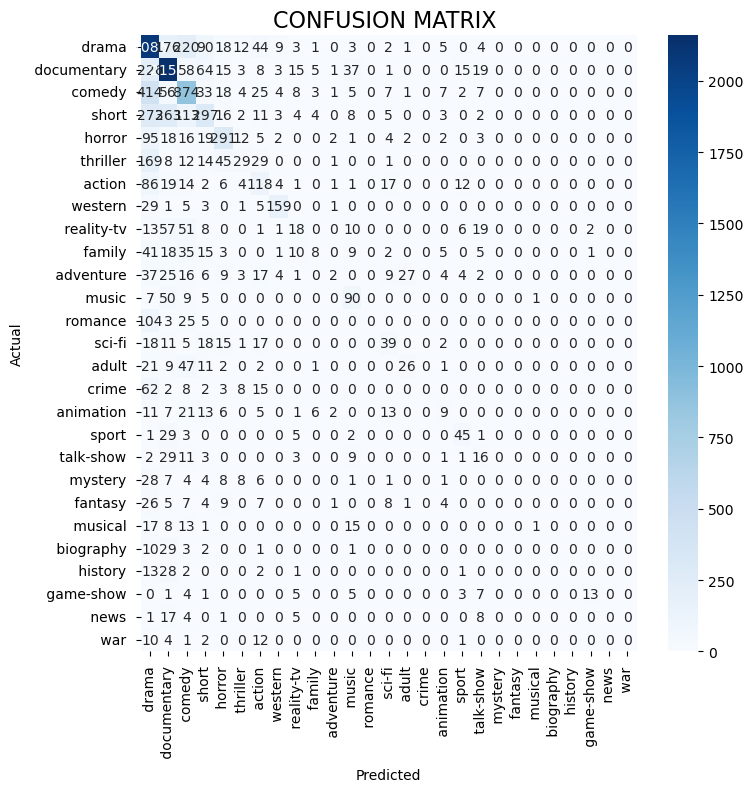

In [49]:
conf_mat = confusion_matrix(y_test, y_pred_labels)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Genre.values,
            yticklabels=category_id_df.Genre.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX ", size=16);

In [50]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred_labels,target_names= test_df['Genre'].unique()))

               precision    recall  f1-score   support

   adventure        0.55      0.78      0.64      2674
      comedy        0.71      0.82      0.76      2629
     western        0.55      0.59      0.57      1469
       drama        0.48      0.30      0.37      1004
   talk-show        0.63      0.62      0.62       472
      horror        0.33      0.09      0.15       308
      family        0.36      0.41      0.38       285
       short        0.84      0.78      0.81       204
     romance        0.23      0.10      0.14       186
 documentary        0.29      0.05      0.09       153
       sport        0.17      0.01      0.02       166
       crime        0.46      0.56      0.50       162
      sci-fi        0.00      0.00      0.00       137
     history        0.36      0.31      0.33       126
    thriller        0.45      0.22      0.29       120
     mystery        0.00      0.00      0.00       100
  reality-tv        0.20      0.10      0.13        94
       mu